[*********************100%%**********************]  6 of 6 completed
Higher Moments of Stock Returns:
           Mean   Std Dev  Skewness  Kurtosis
AAPL   0.001166  0.019616 -0.016437  5.015979
AMZN   0.000930  0.021897  0.072395  4.002087
GOOGL  0.000925  0.019597 -0.059380  3.969401
MSFT   0.001206  0.018610  0.002767  6.630896
NVDA   0.002514  0.032443  0.166863  4.783263
TSLA   0.002092  0.039812  0.212941  3.506451


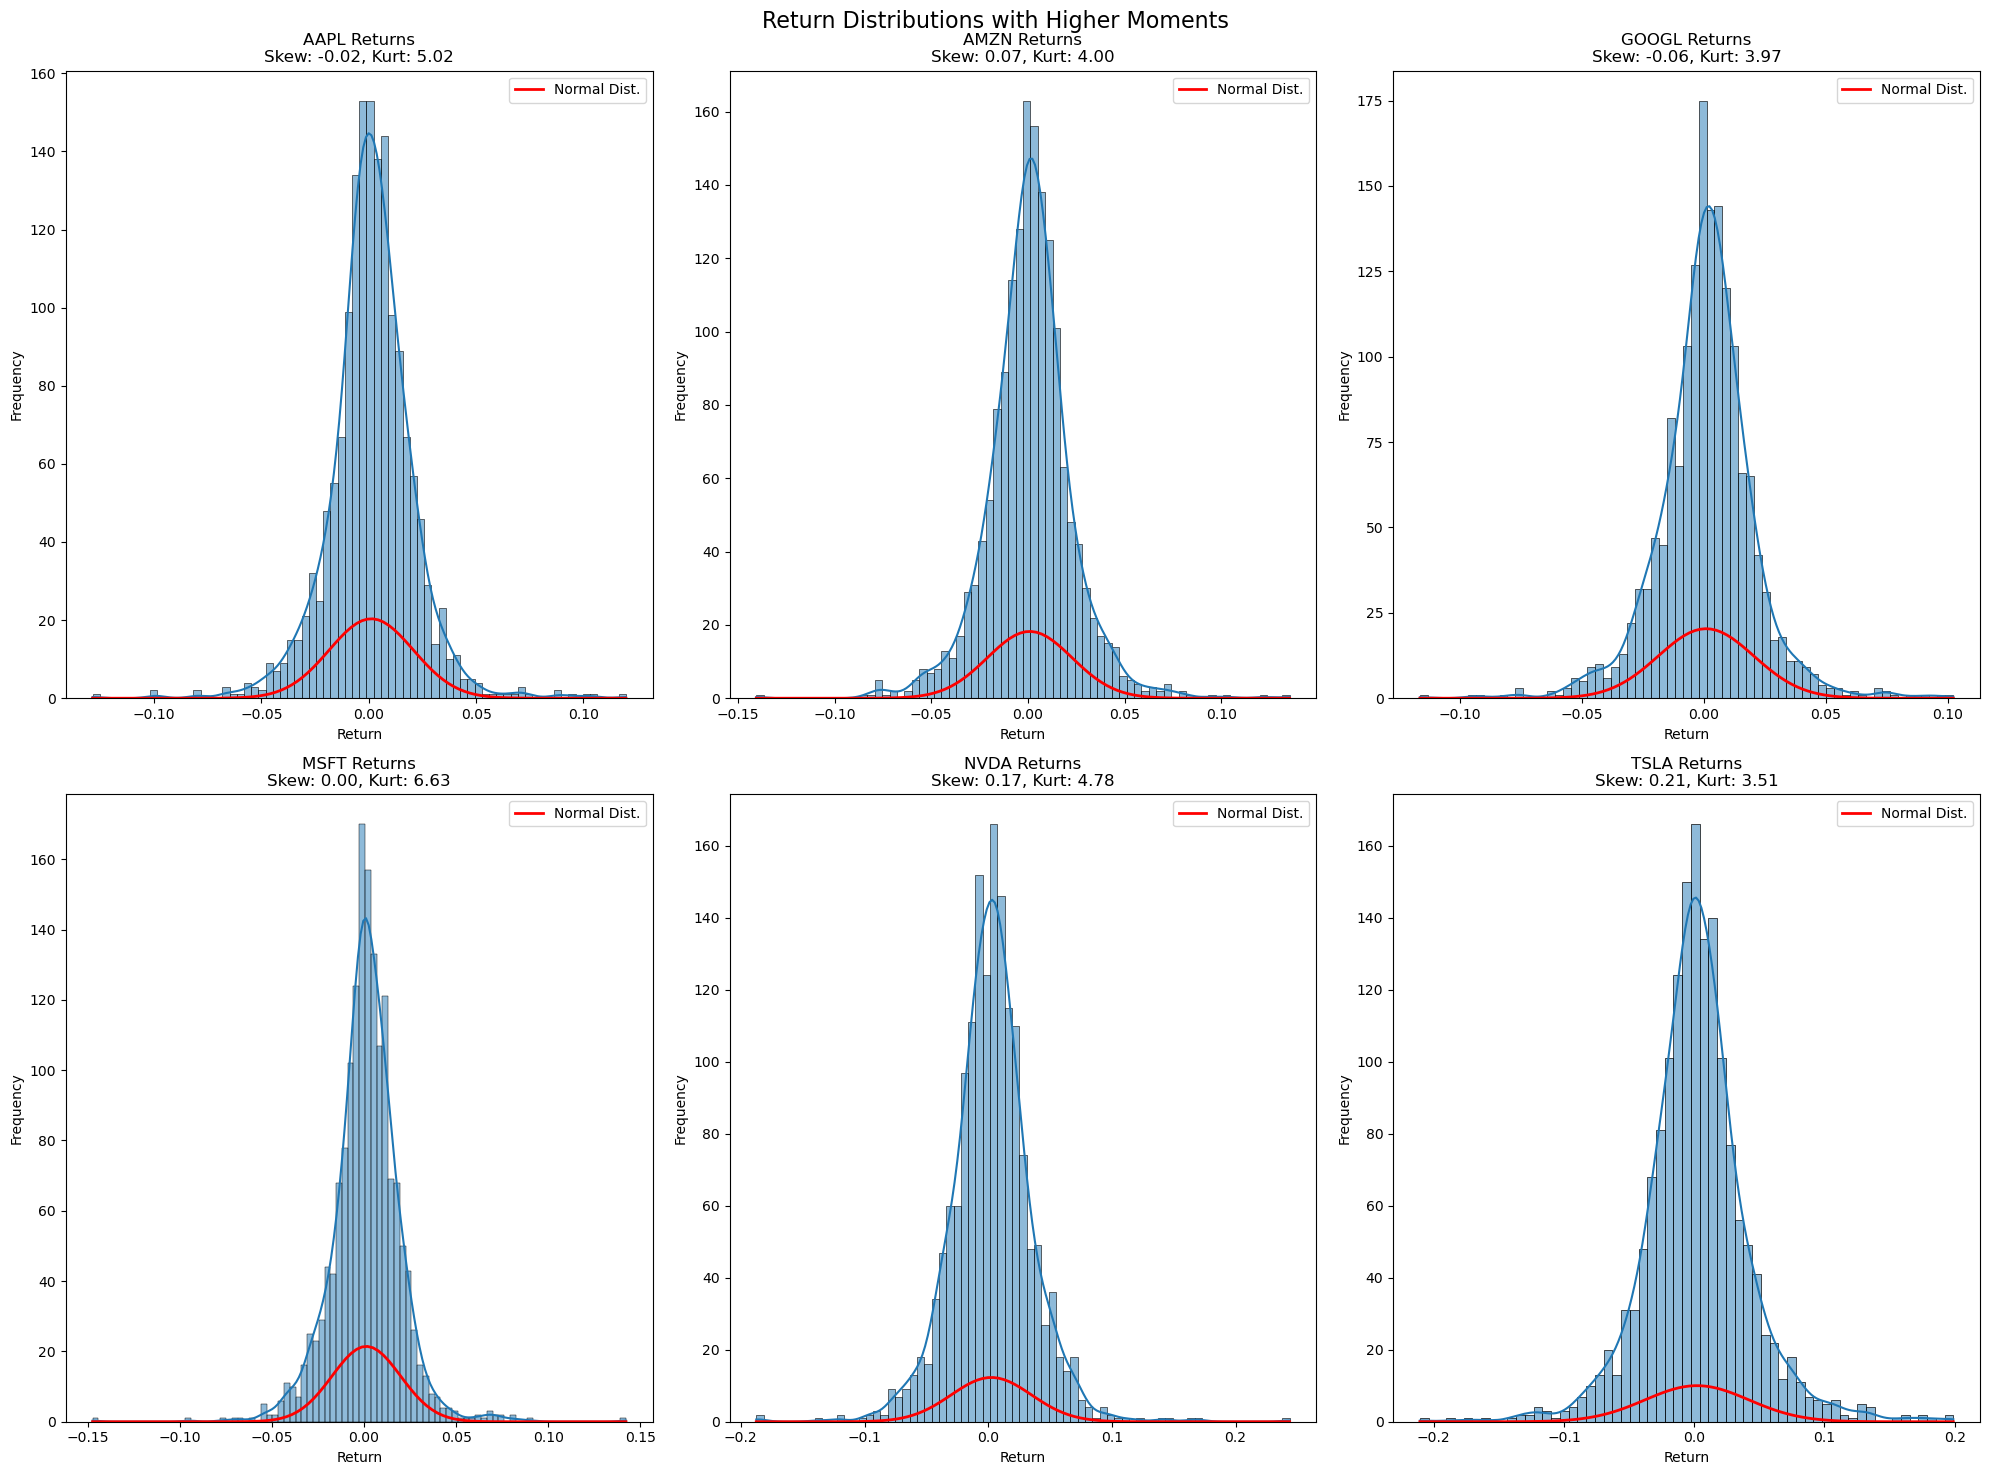

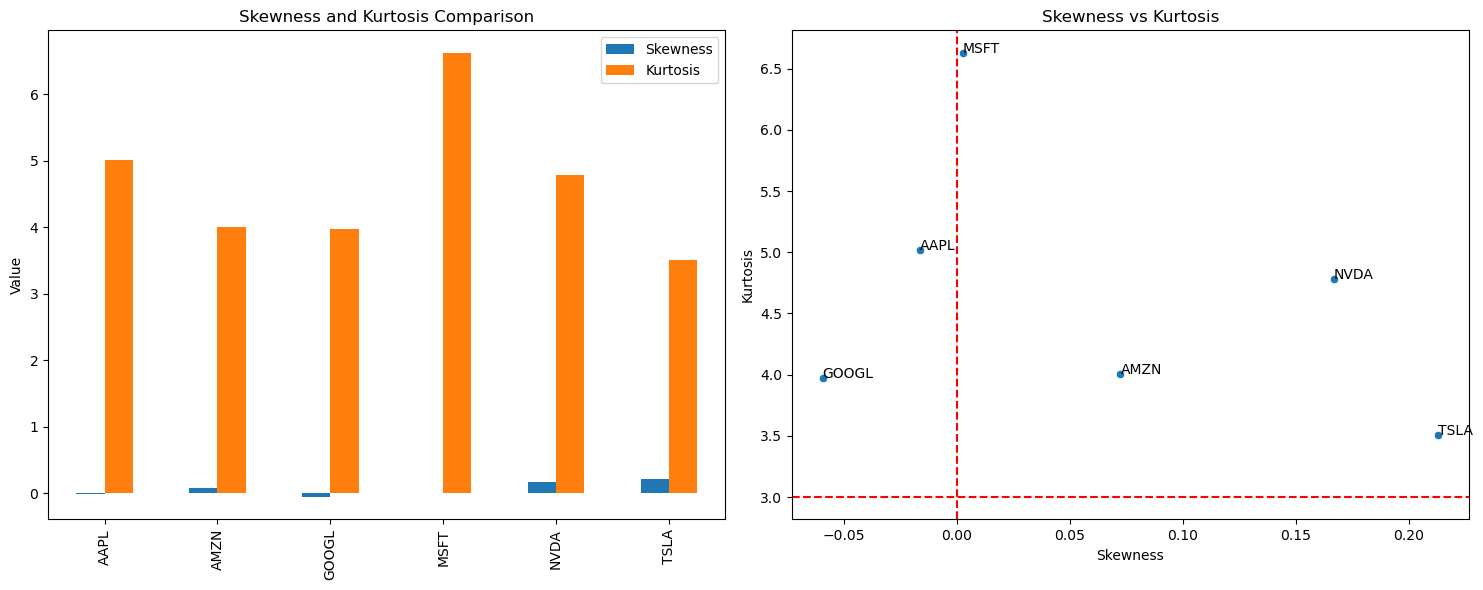

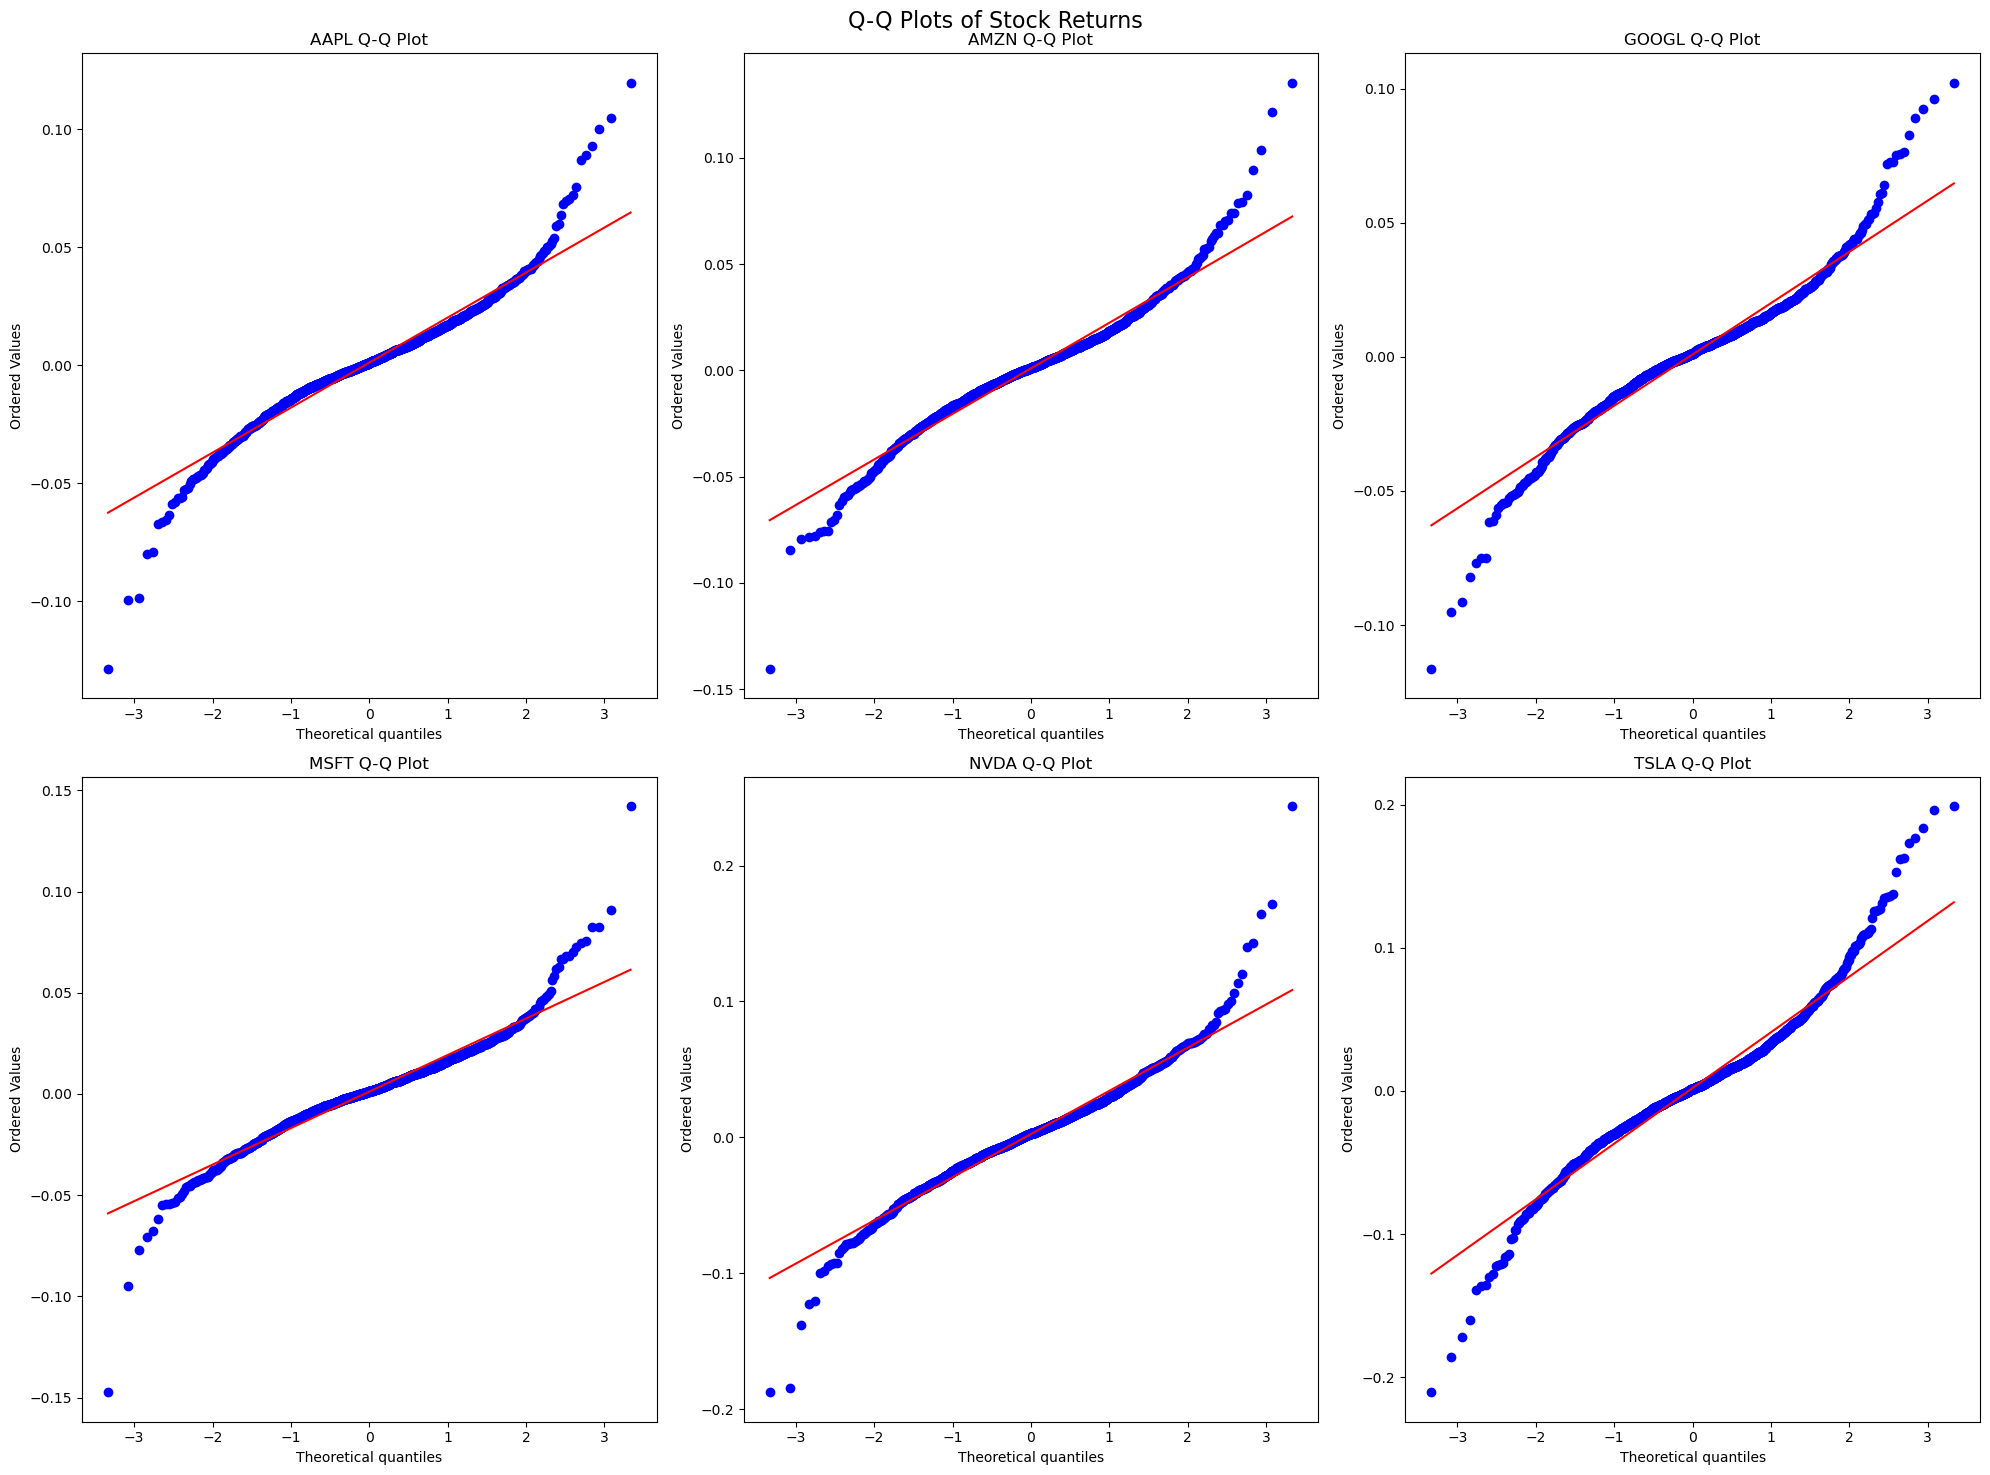

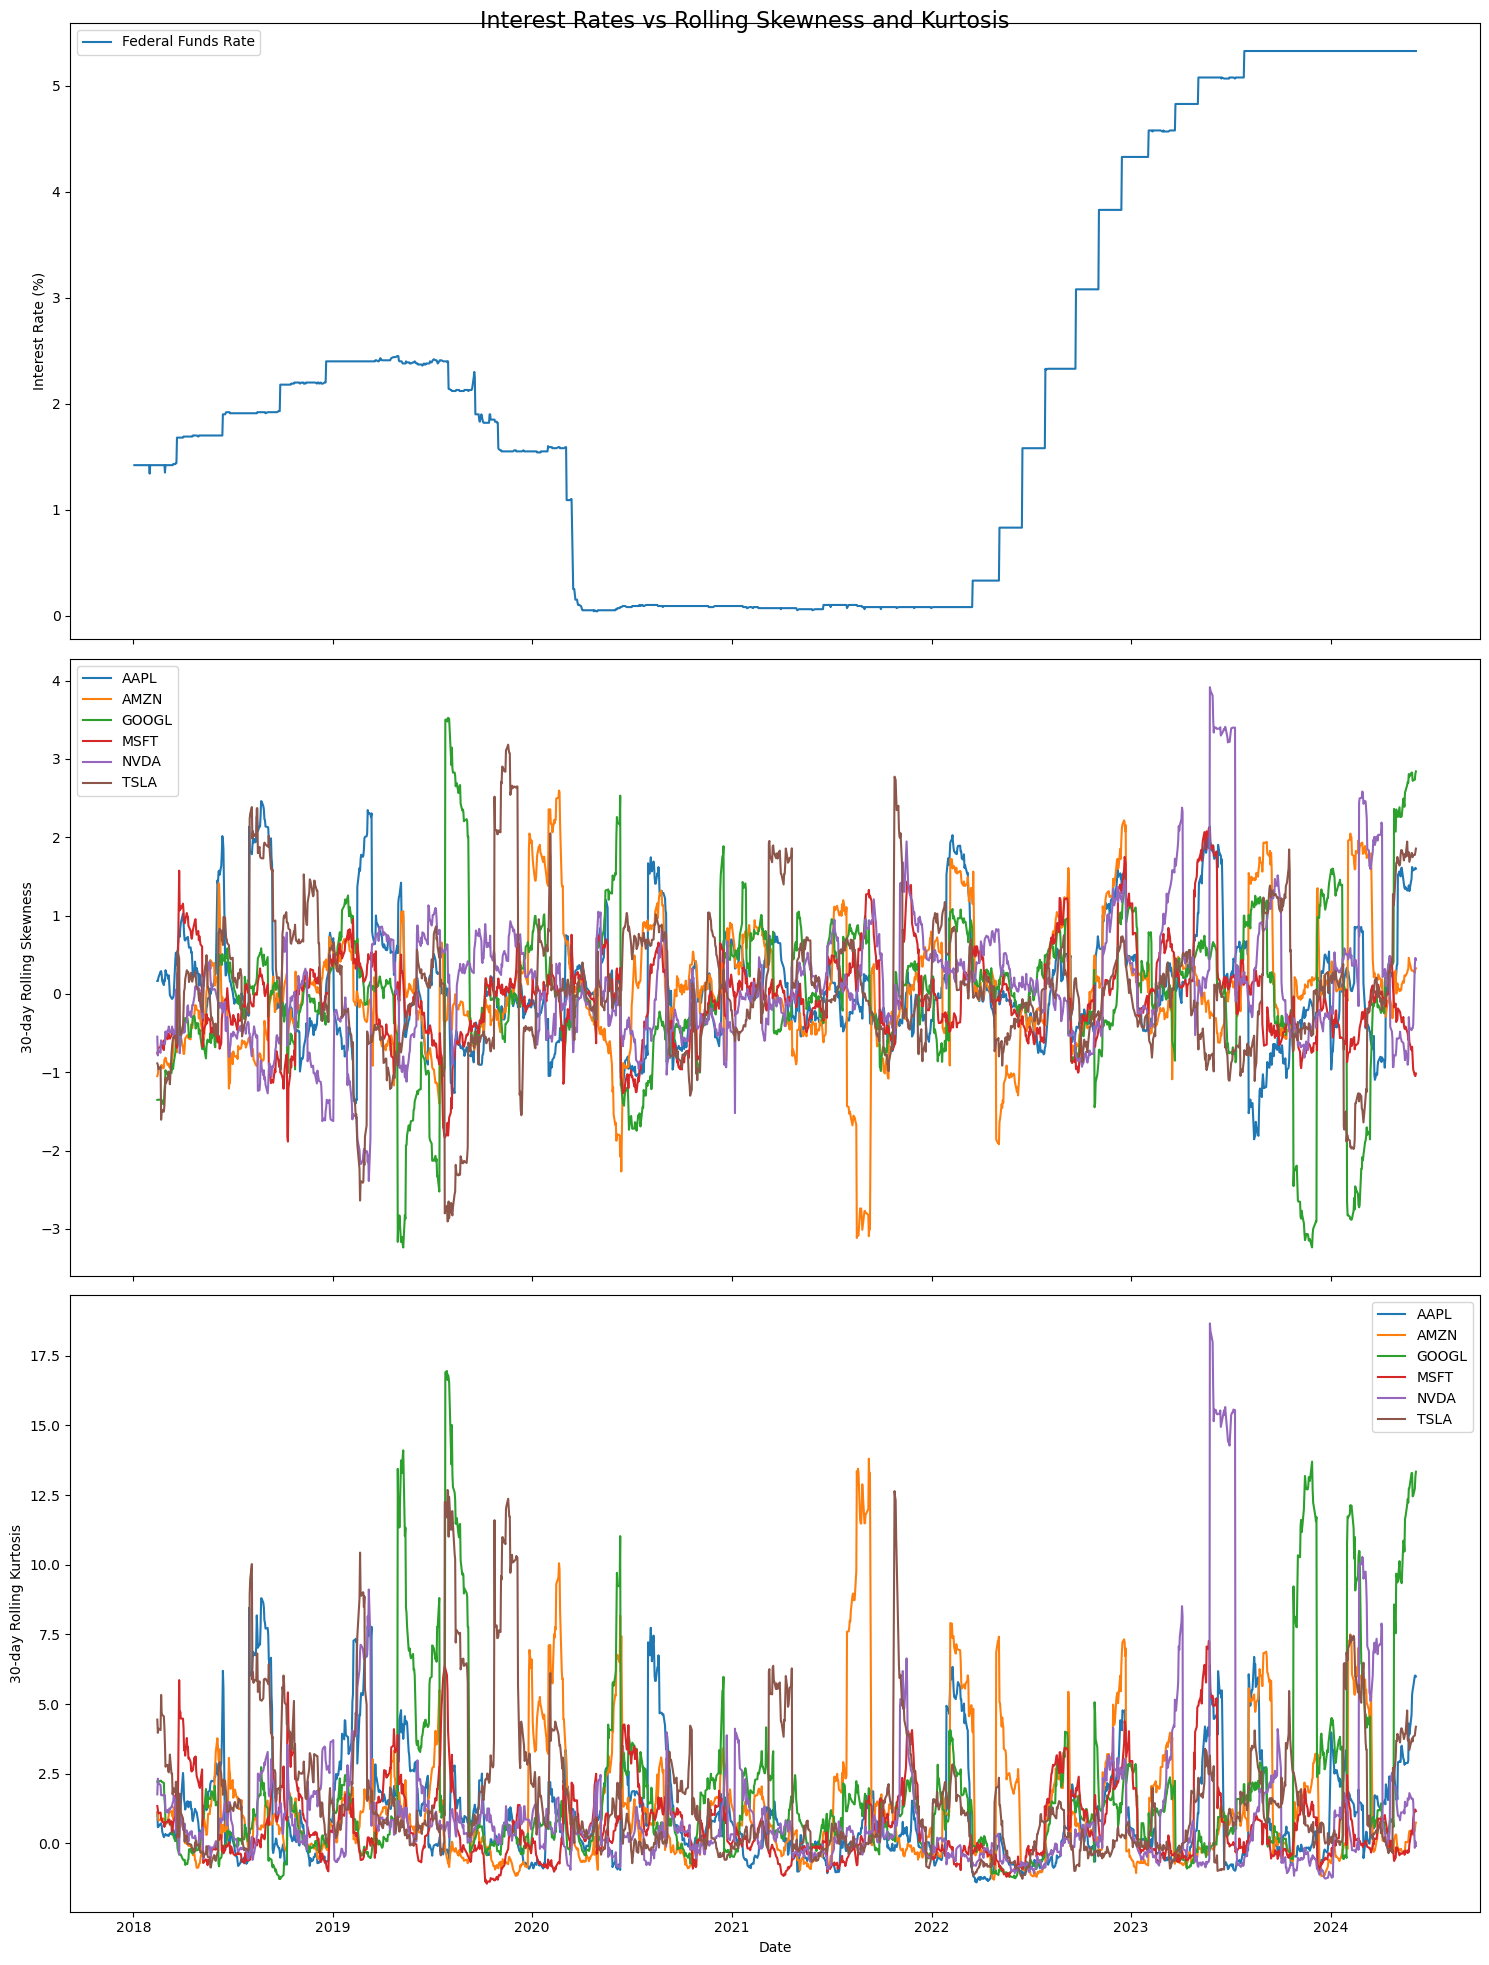


Metrics during interest rate decreases:
           Mean   Std Dev  Skewness   Kurtosis
AAPL  -0.001900  0.026262 -0.864980   7.202000
AMZN   0.000325  0.022615  0.854482   5.894121
GOOGL -0.002091  0.021823 -1.490210   8.415556
MSFT   0.000465  0.024595 -1.635650  14.853744
NVDA   0.002244  0.037254 -0.352208   9.825129
TSLA   0.007020  0.043850  0.340049   6.872829


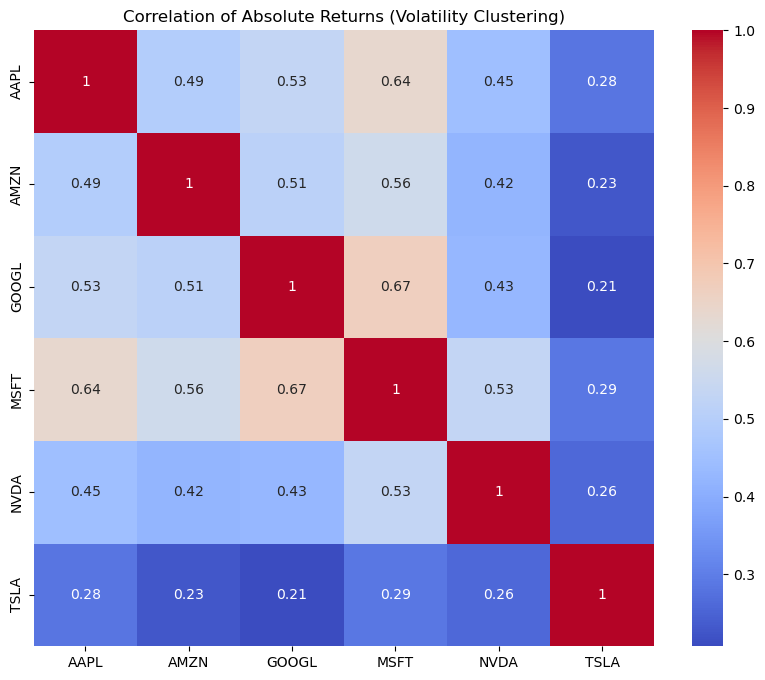


Tail Risk Analysis:
95% Value at Risk (VaR):
AAPL    -0.030001
AMZN    -0.033346
GOOGL   -0.029891
MSFT    -0.029072
NVDA    -0.046881
TSLA    -0.058594
Name: 0.05, dtype: float64

95% Conditional Value at Risk (CVaR):
AAPL    -0.044656
AMZN    -0.049742
GOOGL   -0.045303
MSFT    -0.041321
NVDA    -0.069800
TSLA    -0.087569
dtype: float64

Potential Impacts of High Debt and Decreasing Interest Rates:
1. Increased volatility: Look for higher kurtosis values during rate decrease periods.
2. Potential for positive skewness: Tech stocks might benefit from lower borrowing costs.
3. Changing correlations: Examine if correlations between tech stocks increase during rate decreases.
4. Tail risk changes: Compare VaR and CVaR during normal periods vs rate decrease periods.

Recommendations for Portfolio Optimization:
1. Monitor changes in skewness and kurtosis as interest rates decrease.
2. Consider increasing allocation to tech stocks with positive skewness during rate decreases.
3. Be cautio

In [27]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import fredapi as fred

def get_stock_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    returns = data.pct_change().dropna()
    return returns

def calculate_moments(returns):
    mean = returns.mean()
    std = returns.std()
    skewness = returns.skew()
    kurtosis = returns.kurtosis()
    return pd.DataFrame({'Mean': mean, 'Std Dev': std, 'Skewness': skewness, 'Kurtosis': kurtosis})

def plot_return_distributions(returns, moments):
    fig, axes = plt.subplots(2, 3, figsize=(20, 15))
    fig.suptitle('Return Distributions with Higher Moments', fontsize=16)
    
    for i, col in enumerate(returns.columns):
        ax = axes[i // 3, i % 3]
        sns.histplot(returns[col], kde=True, ax=ax)
        ax.set_title(f'{col} Returns\nSkew: {moments.loc[col, "Skewness"]:.2f}, Kurt: {moments.loc[col, "Kurtosis"]:.2f}')
        ax.set_xlabel('Return')
        ax.set_ylabel('Frequency')
        
        x = np.linspace(returns[col].min(), returns[col].max(), 100)
        ax.plot(x, stats.norm.pdf(x, returns[col].mean(), returns[col].std()), 'r-', lw=2, label='Normal Dist.')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

def plot_moment_comparison(moments):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    moments[['Skewness', 'Kurtosis']].plot(kind='bar', ax=ax1)
    ax1.set_title('Skewness and Kurtosis Comparison')
    ax1.set_ylabel('Value')
    ax1.legend(['Skewness', 'Kurtosis'])
    
    sns.scatterplot(data=moments, x='Skewness', y='Kurtosis', ax=ax2)
    for i, txt in enumerate(moments.index):
        ax2.annotate(txt, (moments['Skewness'].iloc[i], moments['Kurtosis'].iloc[i]))
    ax2.set_title('Skewness vs Kurtosis')
    ax2.axhline(y=3, color='r', linestyle='--')  
    ax2.axvline(x=0, color='r', linestyle='--')  
    
    plt.tight_layout()
    plt.show()

def plot_qq_plots(returns):
    fig, axes = plt.subplots(2, 3, figsize=(20, 15))
    fig.suptitle('Q-Q Plots of Stock Returns', fontsize=16)
    
    for i, col in enumerate(returns.columns):
        ax = axes[i // 3, i % 3]
        stats.probplot(returns[col], dist="norm", plot=ax)
        ax.set_title(f'{col} Q-Q Plot')
    
    plt.tight_layout()
    plt.show()

def get_interest_rates(start_date, end_date):
    fred_client = fred.Fred(api_key='c082aa97310a56a4645a7ebe89d1d432')  
    interest_rates = fred_client.get_series('DFF', start_date, end_date)  
    return interest_rates.resample('D').ffill()  

def plot_metrics_vs_rates(returns, interest_rates):
    aligned_data = pd.concat([returns, interest_rates], axis=1, join='inner')
    aligned_returns = aligned_data.iloc[:, :-1]
    aligned_rates = aligned_data.iloc[:, -1]
    
    rolling_skew = aligned_returns.rolling(window=30).skew()
    rolling_kurt = aligned_returns.rolling(window=30).kurt()
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 20), sharex=True)
    
    axes[0].plot(aligned_rates.index, aligned_rates, label='Federal Funds Rate')
    axes[0].set_ylabel('Interest Rate (%)')
    axes[0].legend()
    
    for column in rolling_skew.columns:
        axes[1].plot(rolling_skew.index, rolling_skew[column], label=column)
    axes[1].set_ylabel('30-day Rolling Skewness')
    axes[1].legend()
    
    for column in rolling_kurt.columns:
        axes[2].plot(rolling_kurt.index, rolling_kurt[column], label=column)
    axes[2].set_ylabel('30-day Rolling Kurtosis')
    axes[2].legend()
    
    plt.xlabel('Date')
    plt.suptitle('Interest Rates vs Rolling Skewness and Kurtosis', fontsize=16)
    plt.tight_layout()
    plt.show()

def analyze_rate_change_periods(returns, interest_rates):
    aligned_data = pd.concat([returns, interest_rates], axis=1, join='inner')
    aligned_returns = aligned_data.iloc[:, :-1]
    aligned_rates = aligned_data.iloc[:, -1]
    
    rate_changes = aligned_rates.diff()
    rate_decrease_periods = rate_changes[rate_changes < 0].index
    
    decrease_returns = aligned_returns.loc[rate_decrease_periods]
    decrease_moments = calculate_moments(decrease_returns)
    
    print("\nMetrics during interest rate decreases:")
    print(decrease_moments)
    
    return decrease_returns, decrease_moments

if __name__ == "__main__":
    tickers = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'NVDA', 'TSLA']
    start_date = '2018-01-01'
    end_date = '2024-06-06'
    
    returns = get_stock_data(tickers, start_date, end_date)
    moments = calculate_moments(returns)
    
    print("Higher Moments of Stock Returns:")
    print(moments)
    
    plot_return_distributions(returns, moments)
    plot_moment_comparison(moments)
    plot_qq_plots(returns)
    
    interest_rates = get_interest_rates(start_date, end_date)
    plot_metrics_vs_rates(returns, interest_rates)
    
    decrease_returns, decrease_moments = analyze_rate_change_periods(returns, interest_rates)
    
    abs_returns = returns.abs()
    correlation_matrix = abs_returns.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation of Absolute Returns (Volatility Clustering)')
    plt.show()
    
    var_95 = returns.quantile(0.05)
    cvar_95 = returns[returns < var_95].mean()
    
    print("\nTail Risk Analysis:")
    print("95% Value at Risk (VaR):")
    print(var_95)
    print("\n95% Conditional Value at Risk (CVaR):")
    print(cvar_95)
    
    print("\nPotential Impacts of High Debt and Decreasing Interest Rates:")
    print("1. Increased volatility: Look for higher kurtosis values during rate decrease periods.")
    print("2. Potential for positive skewness: Tech stocks might benefit from lower borrowing costs.")
    print("3. Changing correlations: Examine if correlations between tech stocks increase during rate decreases.")
    print("4. Tail risk changes: Compare VaR and CVaR during normal periods vs rate decrease periods.")
    
    print("\nRecommendations for Portfolio Optimization:")
    print("1. Monitor changes in skewness and kurtosis as interest rates decrease.")
    print("2. Consider increasing allocation to tech stocks with positive skewness during rate decreases.")
    print("3. Be cautious of increased tail risks - adjust portfolio weights accordingly.")
    print("4. Reassess correlations regularly to maintain effective diversification.")

    print("\nComparison of Moments:")
    print("Overall Moments:")
    print(moments)
    print("\nMoments During Rate Decreases:")
    print(decrease_moments)

    overall_corr = returns.corr()
    decrease_corr = decrease_returns.corr()
    
    print("\nChange in Correlations:")
    print(decrease_corr - overall_corr)

    print("\nKey Insights for Current Economic Conditions:")
    print("1. Tech stocks showing the most sensitivity to interest rate changes:", 
          (decrease_moments['Std Dev'] - moments['Std Dev']).nlargest(2).index.tolist())
    print("2. Stocks with improved upside potential during rate decreases:",
          decrease_moments[decrease_moments['Skewness'] > moments['Skewness']].index.tolist())
    print("3. Stocks with highest tail risk in the current environment:",
          cvar_95.nsmallest(2).index.tolist())
    print("4. Recommendation for diversification:", 
          overall_corr.where(np.triu(np.ones(overall_corr.shape), k=1).astype(bool))
          .stack().nsmallest(1).index.tolist())

    decrease_var_95 = decrease_returns.quantile(0.05)
    decrease_cvar_95 = decrease_returns[decrease_returns < decrease_var_95].mean()
    
    print("\nComparison of Tail Risk Measures:")
    print("Overall VaR:")
    print(var_95)
    print("VaR during rate decreases:")
    print(decrease_var_95)
    print("\nOverall CVaR:")
    print(cvar_95)
    print("CVaR during rate decreases:")
    print(decrease_cvar_95)

    overall_volatility = returns.std()
    decrease_volatility = decrease_returns.std()
    
    print("\nVolatility Comparison:")
    print("Overall Volatility:")
    print(overall_volatility)
    print("Volatility during rate decreases:")
    print(decrease_volatility)
    print("Percentage change in volatility:")
    print(((decrease_volatility - overall_volatility) / overall_volatility) * 100)

## Comparing Interest rates with 30 day rolling Skewness and Kurtosis

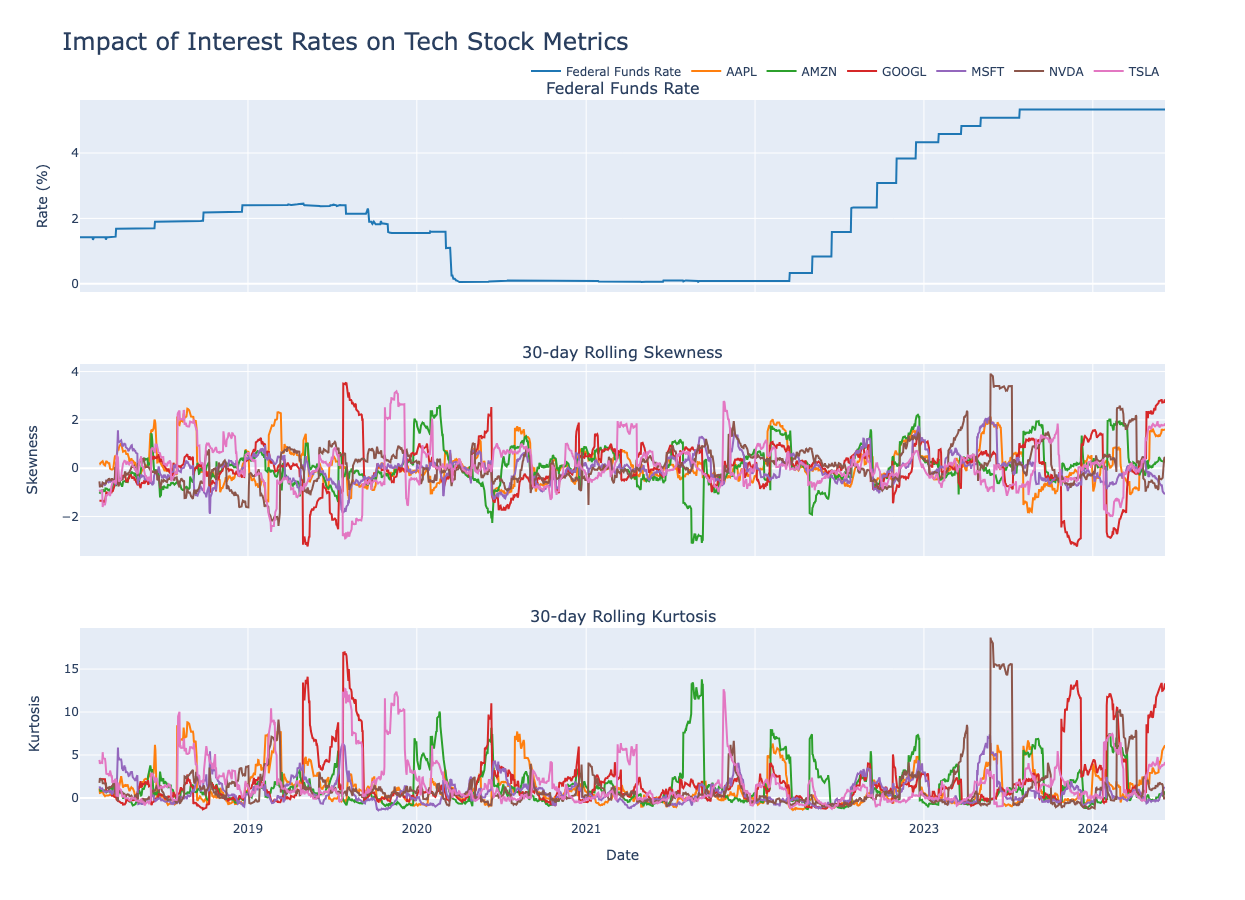

In [28]:

def plot_metrics_vs_rates(returns, interest_rates):
    aligned_data = pd.concat([returns, interest_rates], axis=1, join='inner')
    aligned_returns = aligned_data.iloc[:, :-1]
    aligned_rates = aligned_data.iloc[:, -1]
    
    rolling_skew = aligned_returns.rolling(window=30).skew()
    rolling_kurt = aligned_returns.rolling(window=30).kurt()
    
    # Create subplots
    fig = make_subplots(rows=3, cols=1, 
                        shared_xaxes=True, 
                        vertical_spacing=0.1,
                        subplot_titles=("Federal Funds Rate", "30-day Rolling Skewness", "30-day Rolling Kurtosis"))

    # Add traces for interest rates
    fig.add_trace(
        go.Scatter(x=aligned_rates.index, y=aligned_rates, name="Federal Funds Rate", line=dict(color='#1f77b4')),
        row=1, col=1
    )

    # Color palette for stocks
    colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

    # Add traces for skewness
    for i, column in enumerate(rolling_skew.columns):
        fig.add_trace(
            go.Scatter(x=rolling_skew.index, y=rolling_skew[column], name=f"{column}", line=dict(color=colors[i])),
            row=2, col=1
        )

    # Add traces for kurtosis
    for i, column in enumerate(rolling_kurt.columns):
        fig.add_trace(
            go.Scatter(x=rolling_kurt.index, y=rolling_kurt[column], name=f"{column}", line=dict(color=colors[i]), showlegend=False),
            row=3, col=1
        )

    # Update layout
    fig.update_layout(
        height=900,
        title=dict(
            text="Impact of Interest Rates on Tech Stock Metrics",
            font=dict(size=24)
        ),
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        font=dict(size=12)
    )

    # Update y-axes
    fig.update_yaxes(title_text="Rate (%)", row=1, col=1)
    fig.update_yaxes(title_text="Skewness", row=2, col=1)
    fig.update_yaxes(title_text="Kurtosis", row=3, col=1)

    # Update x-axis
    fig.update_xaxes(title_text="Date", row=3, col=1)

    # Update subplot titles
    for i in range(len(fig.layout.annotations)):
        fig.layout.annotations[i].font.size = 16

    # Show plot
    fig.show()

    # Save as HTML file for easy sharing
    fig.write_html("metrics_vs_rates.html")

    return fig  # Return the figure object for further customization if needed

# Usage in main script:
interest_rates = get_interest_rates(start_date, end_date)
fig = plot_metrics_vs_rates(returns, interest_rates)


fig.write_image("metrics_vs_rates.png", width=1200, height=900)